<a href="https://colab.research.google.com/github/skywalker0803r/mxnet_course/blob/master/mxnet_REINFORCE_Hybrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install mxnet
import sys
import mxnet  
import gym
import numpy as np  
from mxnet import nd,autograd,init
from mxnet.gluon import nn,trainer
import matplotlib.pyplot as plt
from mxnet.gluon import Trainer

# PolicyNetwork

In [0]:
def build_policy(net,num_actions):
  with net.name_scope():
    net.add(nn.Dense(128,activation='relu'))
    net.add(nn.Dense(num_actions))
  return net

test

In [3]:
p = build_policy(nn.HybridSequential(),2)
p.initialize(init=init.Xavier())
x = nd.random.normal(shape=(1,4))
p(x)


[[0.11606808 0.42311054]]
<NDArray 1x2 @cpu(0)>

# main loop

In [0]:
#!sudo pip install box2d-py

0 9.825674767772034
20 58.90464851780043
40 21.714653999407002
60 30.5582993576533
80 35.61601019049733
100 75.00598418910931
120 19.632755694323322
140 86.90068395036039
160 80.57590100471195
180 107.5450598192346
200 187.7486576874927
220 194.78845299451902
240 157.42594450985445
260 155.15158526303813
280 185.04912538224
300 191.35109743273733
320 161.87531863139435
340 190.29194804620994
360 57.08857961130303
380 193.53564867412047
400 133.89052653896715
420 174.78566517511706
440 195.4140475693862
460 181.26945601660117
480 194.51098906324344
500 118.39884743186718
520 194.60166598462268
540 198.01228591334132
560 198.7917542836517
580 192.54148659300228
600 188.70765220275877
620 187.61267540890526
640 195.30393872318837
660 197.20548340705471
680 185.3026542597109
700 198.38783424781002
720 194.67483226373935
740 179.7817588889699
760 190.0689935527329
780 173.6295044016913
800 193.8605395638462
820 197.0508519531203
840 186.07273676695237
860 192.91758361458642
880 156.03845152

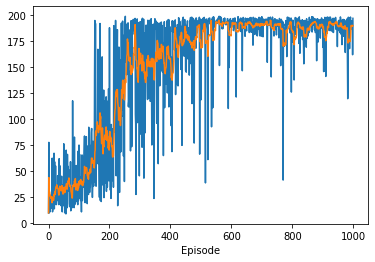

In [5]:
env = gym.make('CartPole-v0')

policy_net = build_policy(nn.HybridSequential(),env.action_space.n)
policy_net.hybridize()
policy_net.initialize(init=init.Xavier())

trainer = Trainer(policy_net.collect_params(),'adam',{'learning_rate':0.001})

max_episode_num = 1000
max_steps = 10000

numsteps = []
avg_numsteps = []

all_rewards = []
avg_all_rewards = []

for episode in range(max_episode_num):
  state = env.reset()
  log_probs = []
  rewards = []
  with autograd.record():
    for t in range(max_steps):
      state = nd.array(np.expand_dims(state, 0))
      
      probs = nd.softmax(policy_net(state))
      action,log_prob = nd.random.multinomial(probs,get_prob=True)
      
      state, reward, done, _ = env.step(action.asnumpy()[0])
      
      # reward engineering
      angle_bias = abs(state[2]-0)
      pos_bias = abs(state[0]-0)
      reward -= 0.1*angle_bias + 0.1*pos_bias
      
      # store memory
      log_probs.append(log_prob)
      rewards.append(reward)
      
      if done:
        break
    
    # logging
    numsteps.append(t)
    avg_numsteps.append(np.mean(numsteps[-10:]))
    
    all_rewards.append(np.sum(rewards))
    avg_all_rewards.append(np.mean(all_rewards[-10:]))

    # reverse accumulate and normalize rewards
    R = 0
    for i in range(len(rewards)-1, -1, -1):
      R = rewards[i] + 0.9 * R
      rewards[i] = R
    rewards = np.array(rewards)
    rewards -= rewards.mean()
    rewards /= rewards.std() + np.finfo(rewards.dtype).eps
      
    # compute loss
    loss = []
    for log_prob,Gt in zip(log_probs,rewards):
      loss.append(log_prob*(-Gt))
    
    # loss backward
    autograd.backward(loss)
  
  # gradient descent
  trainer.step(t)
  
  # print info
  if episode % 20 == 0:
    print(episode,all_rewards[-1])

plt.plot(all_rewards)
plt.plot(avg_all_rewards)
plt.xlabel('Episode')
plt.show()

In [0]:
policy_net.export('my_model',epoch=800)

In [0]:
del policy_net

In [8]:
deserialized_net = nn.SymbolBlock.imports("my_model-symbol.json", 
                                          ['data'], 
                                          "my_model-0800.params")

/usr/local/lib/python3.6/dist-packages/mxnet/gluon/block.py:1159: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


In [15]:

env = gym.make('CartPole-v0')

policy_net = deserialized_net

for episode in range(10):
  state = env.reset()
  rewards = []
  for t in range(max_steps):
    state = nd.array(np.expand_dims(state, 0))
    probs = nd.softmax(policy_net(state))
    action,log_prob = nd.random.multinomial(probs,get_prob=True)
    state, reward, done, _ = env.step(action.asnumpy()[0])
    rewards.append(reward)
    if done:
      break
  
  # print info
  print(episode,np.sum(rewards))

0 200.0
1 200.0
2 200.0
3 200.0
4 200.0
5 200.0
6 200.0
7 200.0
8 200.0
9 200.0
